In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import requests
import nltk
import string
import re
import math
import operator
import os
import csv

from IPython.display import Image 
from itertools import compress
from pylab import rcParams
from collections import Counter
from sklearn.cluster import KMeans 
from nltk.corpus import stopwords
from sklearn import neighbors, tree
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.metrics import silhouette_score
from bs4 import BeautifulSoup

from sklearn import metrics
import pydotplus

from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Load Basic Functions 

In [151]:
# A function that strips all html tags
def striphtml(dat):
    p = re.compile(r'<.*?>') # Regular expression for all html tags
    return p.sub(' ', dat)

# A function that modifies multiple spaces into a single space
def removespace(dat):
    p = re.compile(' +')
    return p.sub(' ', dat)

def get_filtered(sen):
    sentence = sen
    lower = sentence.lower()
    no_punctuation = re.sub(r'[^\w\s]','',lower)
    no_numbers = ''.join([w for w in no_punctuation if not w.isdigit()])
    tokens = nltk.word_tokenize(no_numbers)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return filtered

def unlist(ls):
    output = ''
    for v in ls:
        output = output + " " + v
    return output.strip()

# Euclidean Distance
def distance(p0, p1):
    return np.linalg.norm(p0 - p1)

In [152]:
# Collect all titles in a list
title_list = []

In [153]:
# A function to calculate the frequency of terms and return a wordcount dictionary
def RSNA_parse2(url, threshold, radlex = False, image = False, category = False):
    with urllib.request.urlopen(url) as url:
        sou = url.read()
        soup = BeautifulSoup(sou)

    global kv_pairs
    global kv_pairs2
    global kv_pairs_cat
    global title_list
    
    big_title = soup.find_all('h1')[0].text # title of TF
    title = soup.find_all('h2') # This is a title for each category (ddx, findings...)
    title[0] = 'Document'
    
    history = ''
    discussion = ''
    diagnosis = ''
    findings = ''
    ddx = ''
    
    # Those are the categories I want to remove
    kill_title = ["References", "Files", "Keywords", "Powerpoint Presentation", "Tumor Board Presetations", 
                 "Comments", "Rex shunt evaluation", "Ileocolic Intussusception", "Radiology", "Management",
                 "Clinical Presentation", "Interactive Dataset I", "Pathology", "Follow-up Clinical History",
                 "Instructions", "Document", "Heading", 
                  "AP/lateral radiographs of the right knee. AP/lateral radiographs of both knees two weeks later.",
                 'Images (#1)', 'Images 3 and 4', 'Image 3', 'Section Heading', 'Interactive Dataset II', 
                 'Images (#2)', 'Images 5 and 6', 'Images 4-6', 'Image 7', 'Slides', 'Images 1 and 2']
    
    # Those containers are needed for preprocessing 
    ddx_container = ['Ddx', 'Differential Diagnosis', 'Differential diagnosis', 'Differential', 'Differential Dx',
                    'DDx']
    findings_container = ['Findings (#1)', 'Findings (#2)']

    # Create a title container
    title_bag = []
    
    for t in title:
        clean_title = striphtml(str(t))
        clean_title = clean_title.strip()
        if clean_title not in title_list: # append into the list if title does not exist
            title_list.append(clean_title)

        if clean_title in kill_title:
            continue
        # Preprocessing some categories. For instance, Ddx, DDX, DDx, are all synonyms and can be merged
        elif clean_title in ddx_container:
            clean_title = 'DDX'
            title_bag.append(clean_title)
        elif clean_title in findings_container:
            clean_title = 'Findings'
            title_bag.append(clean_title)
        else:
            title_bag.append(clean_title)   
            
    if image == True:
        temp2 = soup.find_all('body')
    else:
        cnt = 0
        temp2 = soup.find_all('div', class_ = "hide")

        for i in range(len(title_bag)): 
            if i < (len(temp2)-1): 
                if radlex: # Find all terms that linked to RadLex  
                    content = temp2[i+1].find_all('a')
                    for j in range(len(content)):
                        # append terms (ex) abnormal chest becomes abnormal_chest
                        if len(content[j].string.split(' ')) > 1:
                            conn_term = content[j].string.replace(' ', '_')
                        else:
                            conn_term = content[j].string
                        
                        if title_bag[i] == 'History':
                            history = history + conn_term + ' '
                        elif title_bag[i] == 'Findings':
                            findings = findings + conn_term + ' '
                        elif title_bag[i] == 'Discussion':
                            discussion = discussion + conn_term + ' '
                        elif title_bag[i] == 'Diagnosis':
                            diagnosis = diagnosis + conn_term + ' '
                        elif title_bag[i] == 'DDX':
                            ddx = ddx + conn_term + ' '
                            
                        if category: # Create a dictionary based on category
                            if title_bag[i] not in kv_pairs_cat.keys():
                                kv_pairs_cat[title_bag[i]] = [content[j].string]
                            else:
                                kv_pairs_cat[title_bag[i]].append(content[j].string)
                        else:
                            if conn_term not in kv_pairs.keys():
                                kv_pairs[conn_term] = 1
                            else:
                                kv_pairs[conn_term] += 1

                else: # Find all terms
                    content = temp2[i].text
                    # get_filtered removed all stopwords and punctuations. 
                    clean_content = get_filtered(removespace(content))
                    for j in range(len(clean_content)):
                        # Skip wordcount if a term is a title
                        if clean_content[j] in clean_title:
                            pass
                        else:
                            if clean_content[j] not in kv_pairs2.keys():
                                kv_pairs2[clean_content[j]] = 1
                            else:
                                kv_pairs2[clean_content[j]] += 1             

        if radlex:
            kv_pairs = dict((k,v) for k, v in dict(kv_pairs).items() if v >= threshold)
        else:
            kv_pairs2 = dict((k,v) for k, v in dict(kv_pairs2).items() if v >= threshold)
            
    return [big_title, history, findings, discussion, diagnosis, ddx]

# Mimic POST REQUEST

In [154]:
# Type any keyword in 'query' variable
query = ''
payload = {'firstresult':'1', 'maxresults':'5000','orderby':'1','server':'0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15:16:17:18:20:21:22','document':query} # Query
r2 = requests.post("http://mirc.rsna.org/query", data=payload)

# Extract xml files 

In [155]:
# Convert into a beautifulsoup object
bbs = BeautifulSoup(r2.text, "lxml")
corpus = []

In [156]:
# Extract all xml files
kv_pairs = {}
kv_pairs2 = {}
kv_pairs_cat = {}
for xml in bbs.find_all("a", href = True):
    ret = RSNA_parse2(xml['href'], 1, radlex = True, category = True)
#     ret_container += ret
    corpus.append(ret)

In [10]:
# Make lists of terms
history_words = []
findings_words = []
discussion_words = []
diagnosis_words = []
ddx_words = []

title_ls = []

for i in range(len(corpus)):
    # By creating a dictionary I can keep track of the index of teaching file
    
    # append title
    title_ls.append(corpus[i][0])
    
    if corpus[i][1] is not '':  
        temp_dic = {}
        temp_dic[i] = corpus[i][1]
        history_words.append(temp_dic)
    if corpus[i][2] is not '':
        temp_dic = {}
        temp_dic[i] = corpus[i][2]
        findings_words.append(temp_dic)
    if corpus[i][3] is not '':
        temp_dic = {}
        temp_dic[i] = corpus[i][3]
        discussion_words.append(temp_dic)
    if corpus[i][4] is not '':
        temp_dic = {}
        temp_dic[i] = corpus[i][4]
        diagnosis_words.append(temp_dic)
    if corpus[i][5] is not '':
        temp_dic = {}
        temp_dic[i] = corpus[i][5]
        ddx_words.append(temp_dic)


In [11]:
# Now create a list of words
his_w = []
for k in range(len(history_words)):
    his_w.append(list(history_words[k].values())[0].strip())

In [12]:
find_w = []
for k in range(len(findings_words)):
    find_w.append(list(findings_words[k].values())[0].strip())

In [13]:
dis_w = []
for k in range(len(discussion_words)):
    dis_w.append(list(discussion_words[k].values())[0].strip())

In [14]:
dia_w = []
for k in range(len(diagnosis_words)):
    dia_w.append(list(diagnosis_words[k].values())[0].strip())

In [15]:
ddx_w = []
for k in range(len(ddx_words)):
    ddx_w.append(list(ddx_words[k].values())[0].strip())

In [16]:
# Create word frequency dictionary

In [17]:
ddx_freq = {}
for tf in kv_pairs_cat['DDX']:
    # Split word corpus 
    temp_split = tf.strip().split(' ')
    for term in temp_split:
        clean_term = term.lower().replace('_', ' ')
        if clean_term in ddx_freq.keys():
            ddx_freq[clean_term] = ddx_freq[clean_term] + 1
        else:
            ddx_freq[clean_term] = 1

In [18]:
his_freq = {}
for tf in kv_pairs_cat['History']:
    # Split word corpus 
    temp_split = tf.strip().split(' ')
    for term in temp_split:
        clean_term = term.lower().replace('_', ' ')
        if clean_term in his_freq.keys():
            his_freq[clean_term] = his_freq[clean_term] + 1
        else:
            his_freq[clean_term] = 1

In [19]:
dis_freq = {}
for tf in kv_pairs_cat['Discussion']:
    # Split word corpus 
    temp_split = tf.strip().split(' ')
    for term in temp_split:
        clean_term = term.lower().replace('_', ' ')
        if clean_term in dis_freq.keys():
            dis_freq[clean_term] = dis_freq[clean_term] + 1
        else:
            dis_freq[clean_term] = 1

In [20]:
dia_freq = {}
for tf in kv_pairs_cat['Diagnosis']:
    # Split word corpus 
    temp_split = tf.strip().split(' ')
    for term in temp_split:
        clean_term = term.lower().replace('_', ' ')
        if clean_term in dia_freq.keys():
            dia_freq[clean_term] = dia_freq[clean_term] + 1
        else:
            dia_freq[clean_term] = 1

In [21]:
fin_freq = {}
for tf in kv_pairs_cat['Findings']:
    # Split word corpus 
    temp_split = tf.strip().split(' ')
    for term in temp_split:
        clean_term = term.lower().replace('_', ' ')
        if clean_term in fin_freq.keys():
            fin_freq[clean_term] = fin_freq[clean_term] + 1
        else:
            fin_freq[clean_term] = 1

In [182]:
radlex_term_freq_df_ddx = pd.Series(ddx_freq, index=ddx_freq.keys())
radlex_term_freq_df_ddx.to_csv("radlex_term_Freq_ddx.csv", )

In [183]:
radlex_term_freq_df_his = pd.Series(his_freq, index=his_freq.keys())
radlex_term_freq_df_his.to_csv("radlex_term_Freq_his.csv", )

In [184]:
radlex_term_freq_df_dis = pd.Series(dis_freq, index=dis_freq.keys())
radlex_term_freq_df_dis.to_csv("radlex_term_Freq_dis.csv", )

In [185]:
radlex_term_freq_df_dia = pd.Series(dia_freq, index=dia_freq.keys())
radlex_term_freq_df_dia.to_csv("radlex_term_Freq_dia.csv", )

In [186]:
radlex_term_freq_df_fin = pd.Series(fin_freq, index=fin_freq.keys())
radlex_term_freq_df_fin.to_csv("radlex_term_Freq_fin.csv", )

# Term-frequency matrix generator

In [22]:
# Function to calculate TF-IDF
def TFIDF_generator(w, word_list):
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(w)
    
    df = pd.DataFrame(X.toarray(), columns= vectorizer.get_feature_names())
    
    # Get the index of History category
    idx = [list(word_list[x].keys())[0] for x in range(len(word_list))]
    
    df.index = [title_ls[i] for i in idx]
    
    # Now I have a term-frequency matrix with TF index!!!!
    TF = df.T
    
    # Calculate the number of TFs and terms
    numTerms = TF.shape[0]
    nTF = TF.shape[1]
    
    # create IDF
    DF = np.array([(TF!=0).sum(1)]).T
    
    # Create a matrix with all entries to be the number of TFs
    NMatrix=np.ones(np.shape(TF), dtype=float)*nTF
    np.set_printoptions(precision=2,suppress=True,linewidth=120)

    # Convert each entry into IDF values
    # Note that IDF is only a function of the term, so all rows will be identical.
    IDF = np.log2(np.divide(NMatrix, DF))

    # Calculate TF-IDF
    TFIDF = TF * IDF
    
    return TF, TFIDF

## History 

In [158]:
his_tf, his_tfidf = TFIDF_generator(his_w, history_words)
his_tf.T.to_csv("his_term_freq.csv")

## Findings 

In [159]:
find_tf, find_tfidf = TFIDF_generator(find_w, findings_words)
find_tf.T.to_csv("find_term_freq.csv")

## Discussion 

In [160]:
dis_tf, dis_tfidf = TFIDF_generator(dis_w, discussion_words)
dis_tf.T.to_csv("dis_term_freq.csv")

## Diagnosis 

In [161]:
dia_tf, dia_tfidf = TFIDF_generator(dia_w, diagnosis_words)
dia_tf.T.to_csv("dia_term_freq.csv")

## DDX 

In [162]:
ddx_tf, ddx_tfidf = TFIDF_generator(ddx_w, ddx_words)
ddx_tf.T.to_csv("ddx_term_freq.csv")

# Hierarchical Clustering & Dendogram interpretation

## DDX 

In [32]:
# generate the linkage matrix
Z = linkage(ddx_tf.T, 'ward')

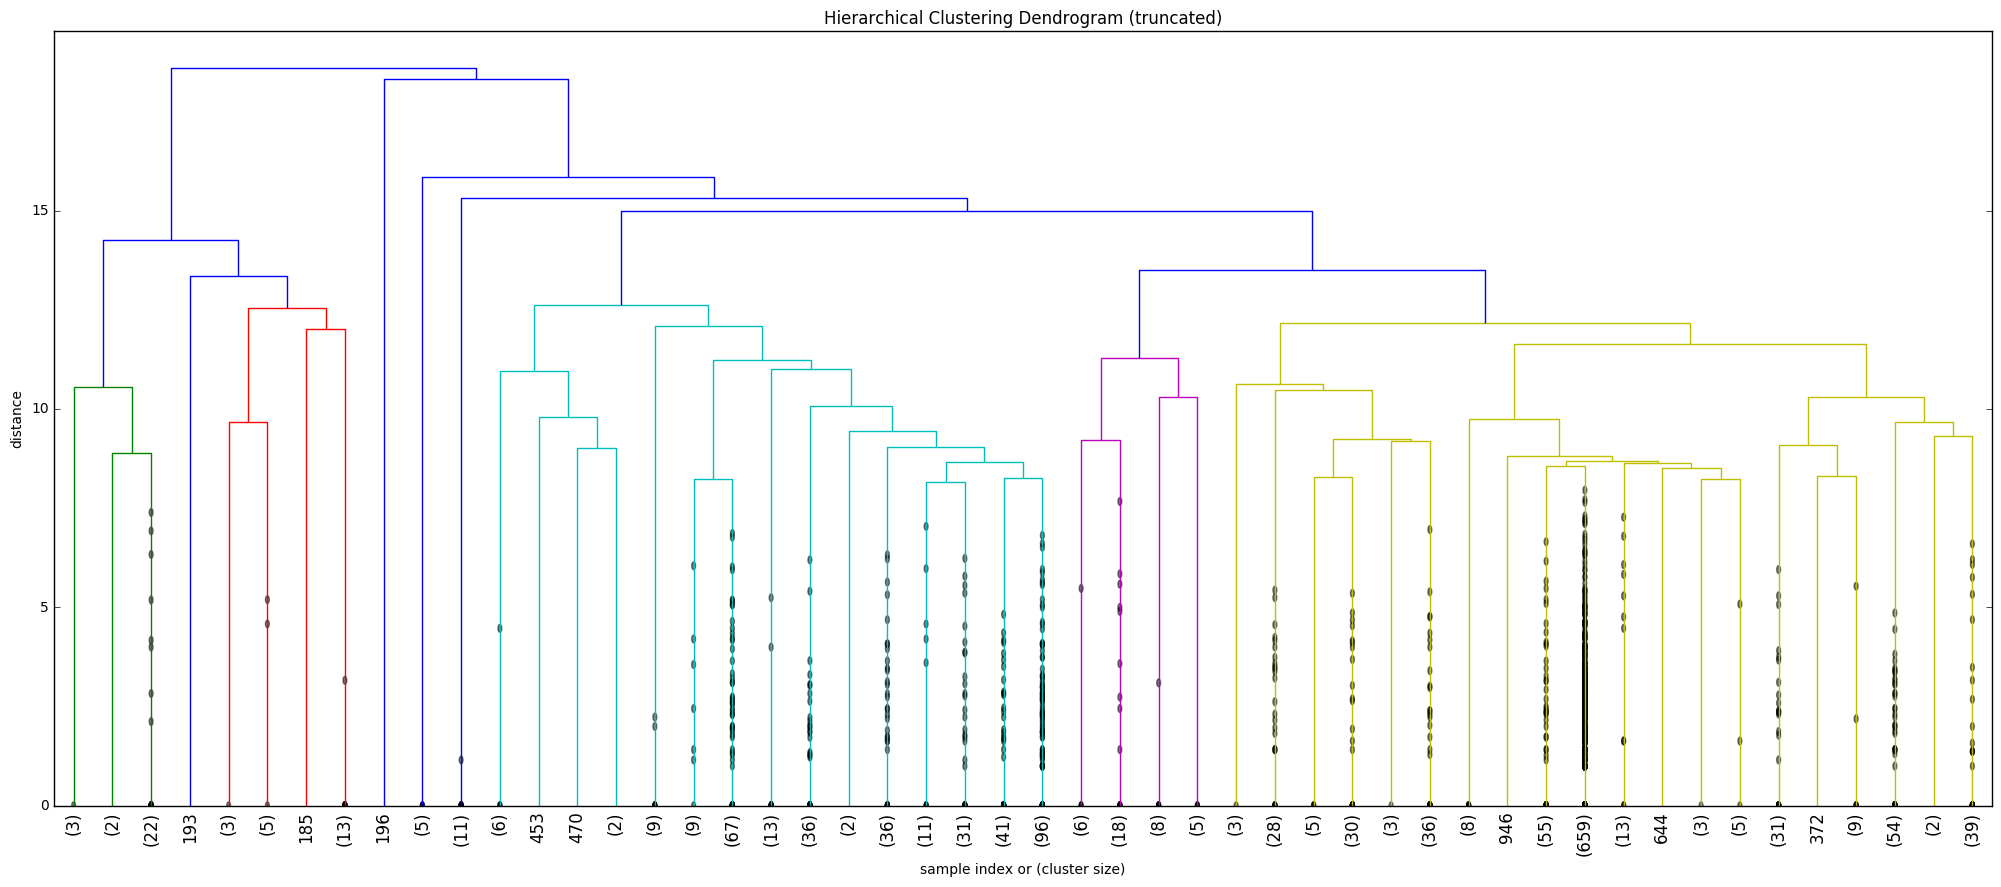

In [33]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [37]:
def DTree_Calculate_Accr(df, z):
    acc_ls = []
    
    for t in range(2, 300, 2):
        # Figure out the membership of each cluster
        membership = fcluster(z, t, criterion='maxclust')
        temp_ddx_tf = df.T
        temp_ddx_tf['Membership'] = membership.tolist()  

        # Remove all cases where the total count is 1
        if np.sum(temp_ddx_tf.Membership.value_counts() >= 1):
            # Extract cluster membership that does have more than one observation
            list_a = [x for x in range(1,t+1)]
            fil = temp_ddx_tf['Membership'].value_counts() != 1
            # Sort by dataframe index
            fil.sort_index(inplace=True)
            cm_needed_ls = list(compress(list_a, fil))

            # Boolean index to filter out
            haha = [True if x in cm_needed_ls else False for x in temp_ddx_tf['Membership']]

            # Our final df
            final_dt = temp_ddx_tf[haha]

            x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(final_dt,
                            final_dt['Membership'],train_size=.8, stratify=final_dt['Membership'], random_state = 33)
        else:
            x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(temp_ddx_tf,
                temp_ddx_tf['Membership'],train_size=.8, stratify=temp_ddx_tf['Membership'], random_state = 33)

        treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=30)
        treeclf = treeclf.fit(x_train, tar_train)

        # Accuracy on Test Set
        acc = treeclf.score(x_test, tar_test)
        acc_ls.append(acc)
        print('Tree ', t, ' has ',acc,' accuracy!')
        
#         #treecm = confusion_matrix(tar_test, treepreds_test)    
        
    return acc_ls, temp_ddx_tf, membership

In [163]:
# Scree plot for accuracy
acc, td, memb = DTree_Calculate_Accr(his_tf, Z)

In [295]:
# Figure out the membership of each cluster
membership = fcluster(Z, 50, criterion='maxclust')
temp_tf = ddx_tf.T
temp_tf['Membership'] = membership.tolist()  

In [240]:
for c in range(1, 51):
    temp_tf['Membership'] = membership.tolist() 
    temp_tf.loc[temp_tf['Membership'] != c, 'Membership'] = 0
    temp_tf.loc[temp_tf['Membership'] == c, 'Membership'] = 1
    
    # subset for storing teaching file title for 'c' cluster
#     subset_tf = temp_tf[temp_tf.Membership == 1]
    
#     for x, content in enumerate(list(subset_tf.index)):
#         if x == 0:
#             tf_writer.writerow(str(3)+","+str(len(subset_tf.index))+","+content+"\n")
#         else:
#             print(content)
#             tf_writer.writerow(",,"+content+"\n")
    
    x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(ddx_tf.T,
        temp_tf['Membership'], train_size=.8, random_state = 33)

    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])
    
    # retrieve sig terms in decision tree
    sig_feature_idx = list(set([x for x in list(treeclf.tree_.feature) if x != -2]))
    # print terms
    print("Cluster "+str(c)+" : ")
    print(list(ddx_tf.index[sig_feature_idx]))
    
# f.close()

Cluster 1 : 
['bones']
Cluster 2 : 
['cartilage']
Cluster 3 : 
['small', 'dysplasia']
Cluster 4 : 
['chronic']
Cluster 5 : 
['severe', 'renal_failure']
Cluster 6 : 
['genetic']
Cluster 7 : 
['central_nervous_system']
Cluster 8 : 
['tethered']
Cluster 9 : 
['calcifications']
Cluster 10 : 
['dislocation']
Cluster 11 : 
['ovaries']
Cluster 12 : 
['glioblastoma_multiforme']
Cluster 13 : 
['tuber_cinereum']
Cluster 14 : 
['pleomorphic']
Cluster 15 : 
['mesoblastic_nephroma']
Cluster 16 : 
['liver']
Cluster 17 : 
['kidney', 'abscess', 'sarcoma', 'solid', 'teratoma', 'medium', 'rhabdomyosarcoma', 'infection', 'invasive', 'benign', 'chronic', 'tumor', 'clear_cell_sarcoma', 'count', 'pheochromocytoma', 'fever']
Cluster 18 : 
['bone_cyst', 'osteomyelitis', 'benign']
Cluster 19 : 
['polyp', 'child', 'abscess', 'osteomyelitis', 'chordoma', 'rhabdomyosarcoma', 'infection', 'neurofibroma', 'rectum', 'hemorrhage', 'lipoma']
Cluster 20 : 
['origin']
Cluster 21 : 
['abscess', 'cystic', 'epidermoid', 'l

## Findings

In [164]:
acc, td, memb = DTree_Calculate_Accr(find_tf, Z)

In [70]:
# generate the linkage matrix
Z = linkage(find_tf.T, 'ward')

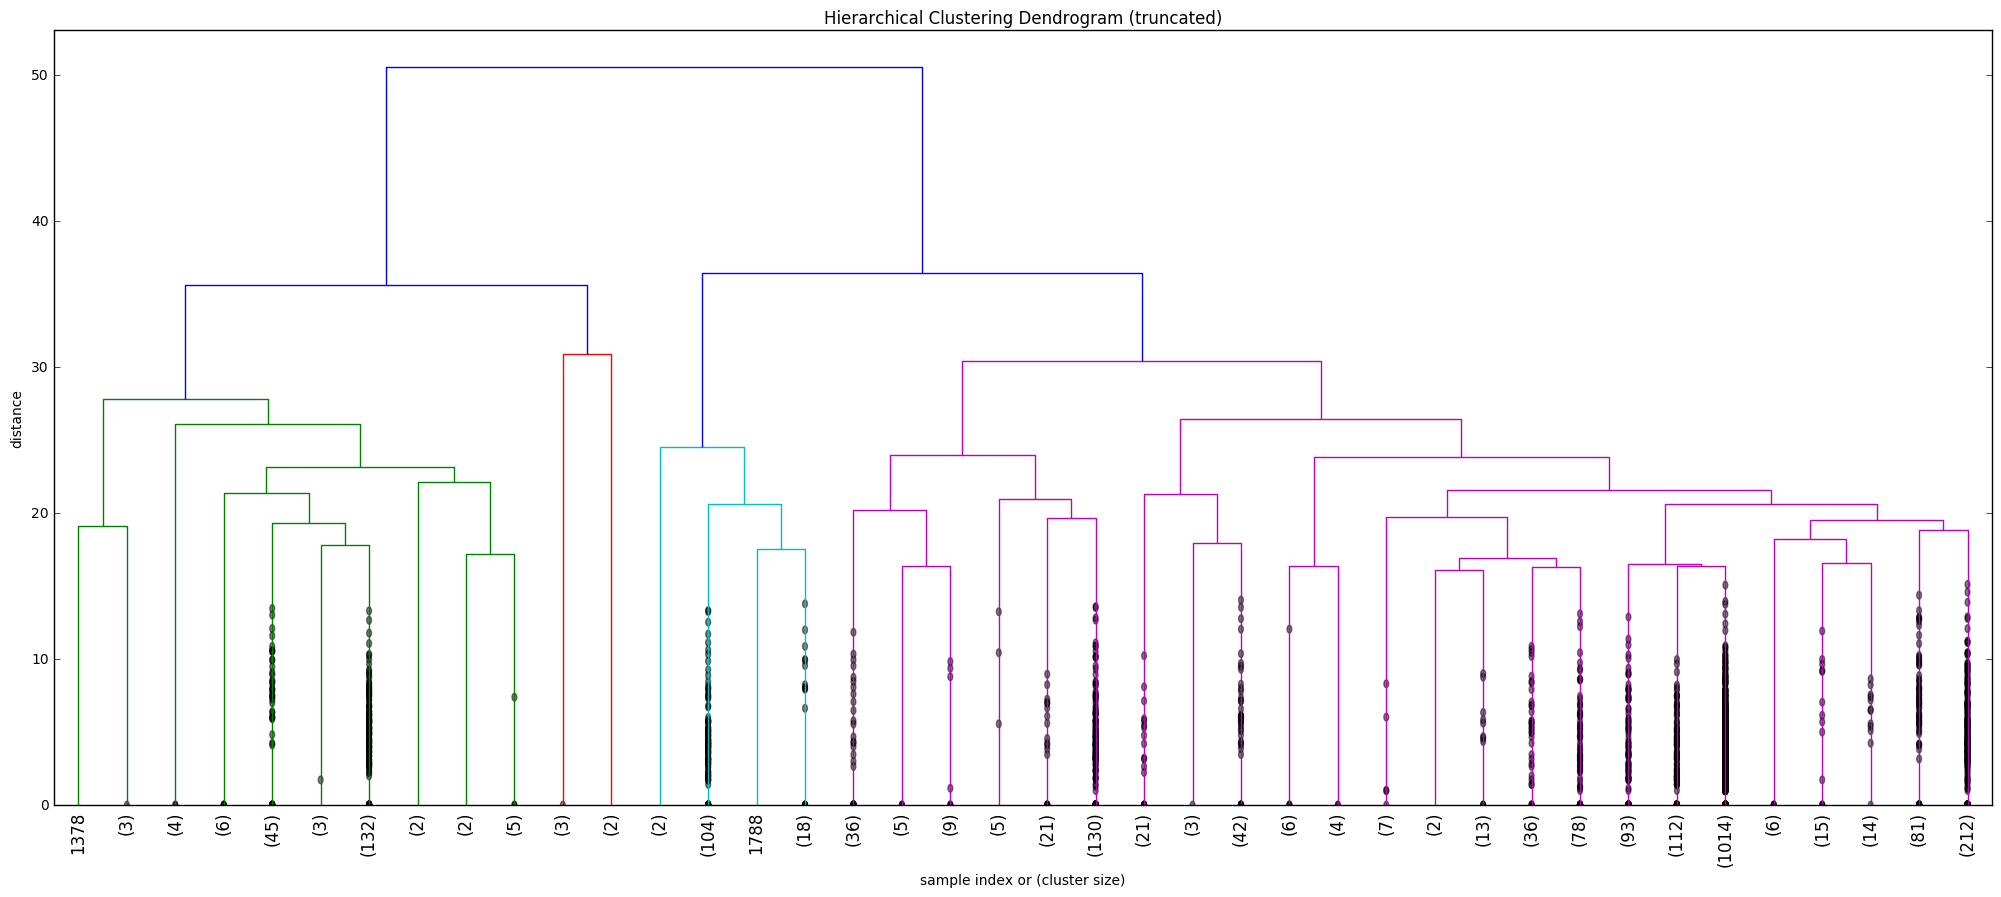

In [71]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=40,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

## Diagnosis

In [33]:
# generate the linkage matrix
Z = linkage(dia_tf.T, 'ward')

In [165]:
# Scree plot for accuracy
acc, td, memb = DTree_Calculate_Accr(dia_tf, Z)

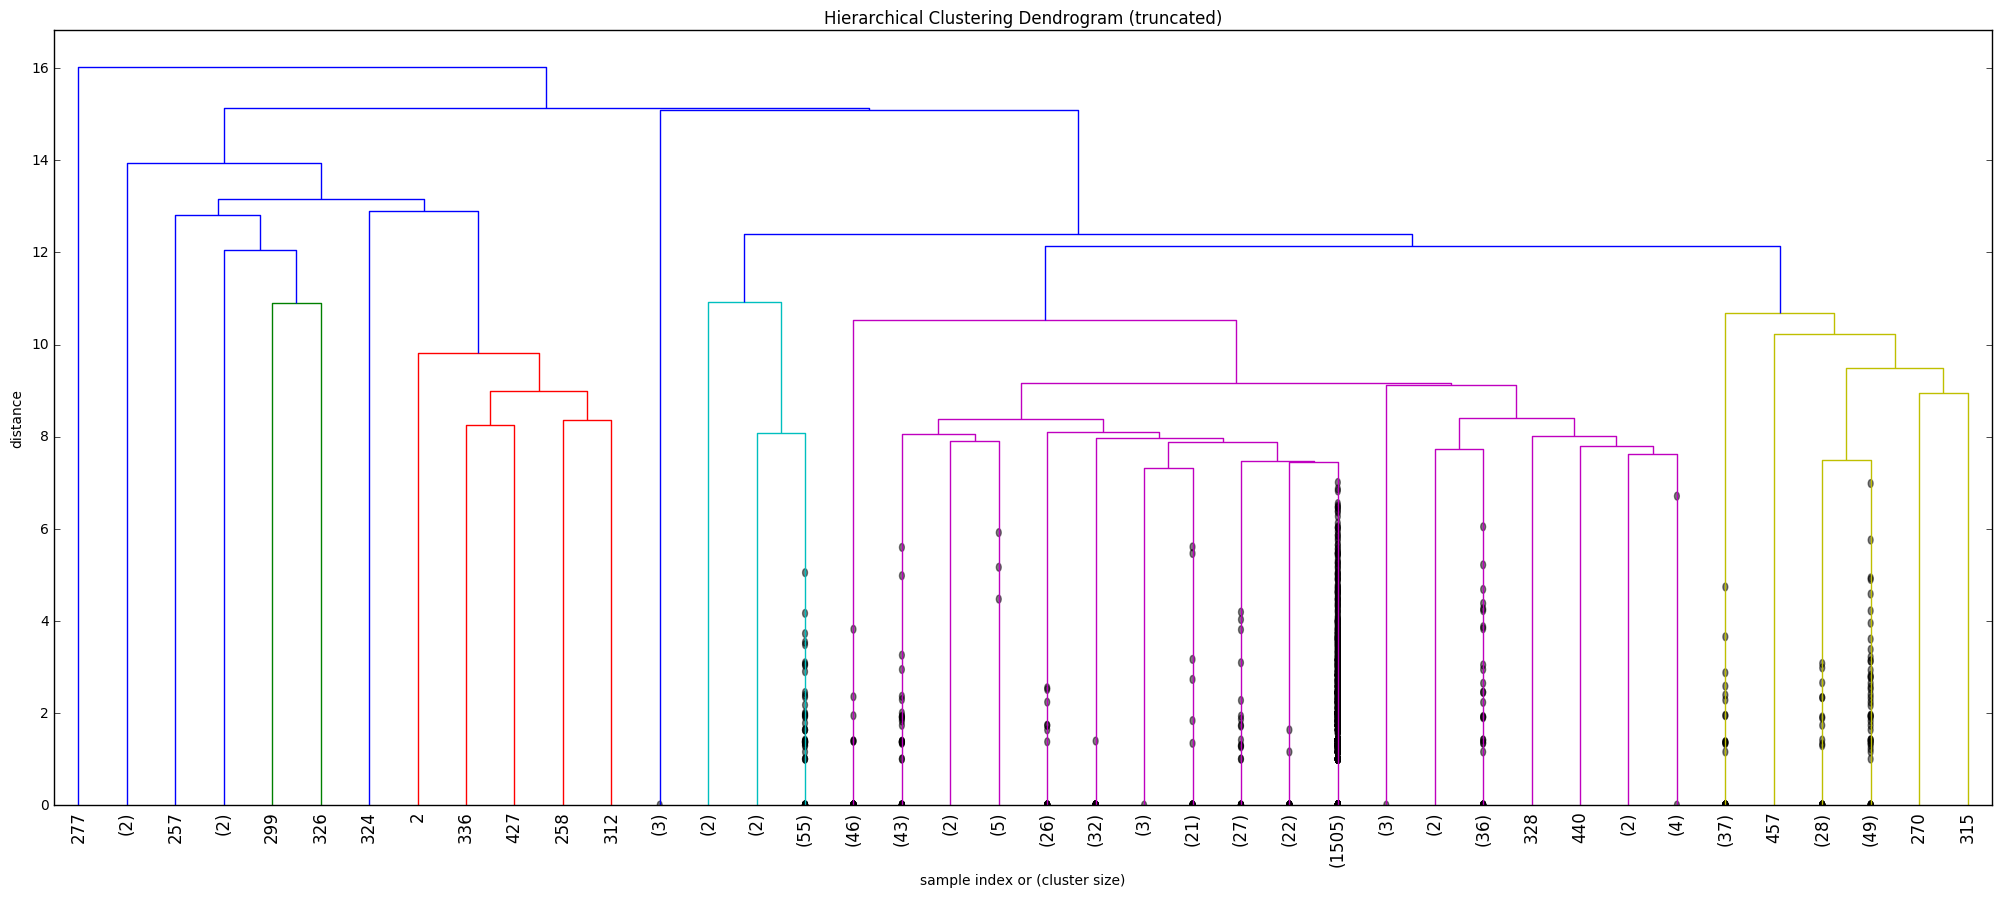

In [34]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=40,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

## Discussion 

In [34]:
# generate the linkage matrix
Z = linkage(dis_tf.T, 'ward')

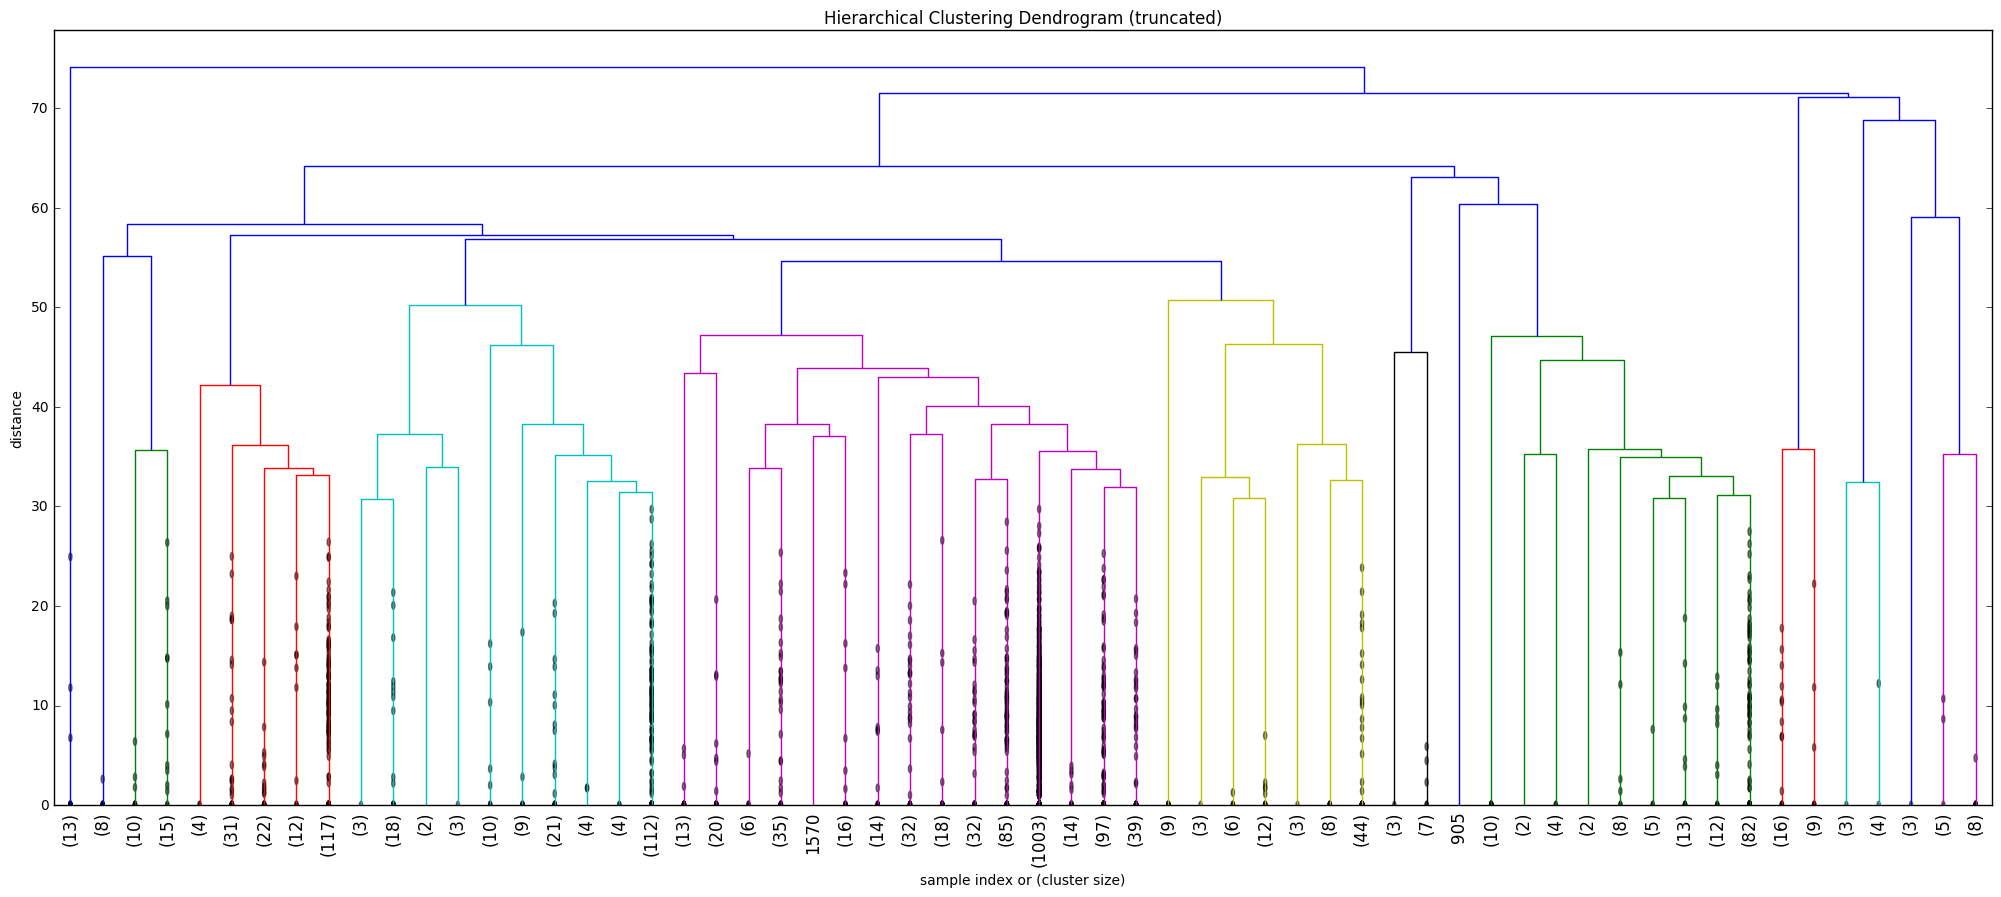

In [39]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=60,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

# Multiple Decision Trees

In [40]:
# Figure out the membership of each cluster
membership = fcluster(Z, 60, criterion='maxclust')
temp_tf = dis_tf.T
temp_tf['Membership'] = membership.tolist() 

In [41]:
for c in range(1, 61):
    temp_tf['Membership'] = membership.tolist() 
    temp_tf.loc[temp_tf['Membership'] != c, 'Membership'] = 0
    temp_tf.loc[temp_tf['Membership'] == c, 'Membership'] = 1
    
    x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(dis_tf.T,
        temp_tf['Membership'], train_size=.8, random_state = 33)

    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])
    
    # retrieve sig terms in decision tree
    sig_feature_idx = list(set([x for x in list(treeclf.tree_.feature) if x != -2]))
    # print terms
    print("Cluster "+str(c)+" : "+dis_tf.index[sig_feature_idx])

    with open("dis"+str(c)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)
        
    os.unlink("dis"+str(c)+".dot")
    
    dot_data = tree.export_graphviz(treeclf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("dis"+str(c)+".pdf") 

Index(['Cluster 1 : tumor'], dtype='object')
Index(['Cluster 2 : infection', 'Cluster 2 : periosteum'], dtype='object')
Index(['Cluster 3 : child_abuse'], dtype='object')
Index(['Cluster 4 : fracture', 'Cluster 4 : physis', 'Cluster 4 : diagnosis'], dtype='object')
Index(['Cluster 5 : glioma'], dtype='object')
Index(['Cluster 6 : hepatocellular_carcinoma', 'Cluster 6 : tumor',
       'Cluster 6 : severe', 'Cluster 6 : liver', 'Cluster 6 : fluid',
       'Cluster 6 : neuroblastoma', 'Cluster 6 : hepatoblastoma'],
      dtype='object')
Index(['Cluster 7 : chemotherapy', 'Cluster 7 : liver', 'Cluster 7 : fibroid'], dtype='object')
Index(['Cluster 8 : carcinoid', 'Cluster 8 : kidney'], dtype='object')
Index(['Cluster 9 : germ_cell', 'Cluster 9 : solid', 'Cluster 9 : abnormal',
       'Cluster 9 : chemotherapy', 'Cluster 9 : glioma',
       'Cluster 9 : hyperintense', 'Cluster 9 : enhancement',
       'Cluster 9 : second', 'Cluster 9 : present', 'Cluster 9 : intracranial',
       'Cluster 9

# Category Analysis

## DDX

In [87]:
def DTree_Calculate_Accr2(df, z):
    
    # Figure out the membership of each cluster
    membership = fcluster(z, 50, criterion='maxclust')
    temp_ddx_tf = df.T
    temp_ddx_tf['Membership'] = membership.tolist()  

    return temp_ddx_tf, membership

In [88]:
ddf, membership = DTree_Calculate_Accr2(ddx_tf, Z)

### Separate into 5 big clusters

In [89]:
# Big clusters
big_clus1_df = ddf[ddf.Membership <= 3]
big_clus2_df = ddf[ddf.Membership >= 4]
big_clus2_df = big_clus2_df[big_clus2_df.Membership <= 7]
big_clus3_df = ddf[ddf.Membership >= 8]
big_clus3_df = big_clus3_df[big_clus3_df.Membership <= 25]
big_clus4_df = ddf[ddf.Membership >= 26]
big_clus4_df = big_clus4_df[big_clus4_df.Membership <= 29]
big_clus5_df = ddf[ddf.Membership >= 30]

In [90]:
idx = 1

In [255]:
def Separate_Clusters(df):
    global idx
    big_clus_freq = {}
    for row in range(df.shape[0] - 1):
        temp_row = df.ix[row,:]
        for a in range(df.shape[1] - 2):
            if temp_row.index[a] not in big_clus_freq.keys():
                big_clus_freq[temp_row.index[a]] = temp_row[a]
            else:
                big_clus_freq[temp_row.index[a]] += temp_row[a]   
    big_clus = pd.Series(big_clus_freq, index=big_clus_freq.keys())
    big_clus.to_csv("big_clus"+str(idx)+".csv")
    print("big_clus"+str(idx)+".csv file saved!")
    idx += 1    

In [92]:
Separate_Clusters(big_clus1_df)
Separate_Clusters(big_clus2_df)
Separate_Clusters(big_clus3_df)
Separate_Clusters(big_clus4_df)
Separate_Clusters(big_clus5_df)
idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!
big_clus4.csv file saved!
big_clus5.csv file saved!


### Big Cluster Analysis

In [93]:
tm1 = [1 if x <= 3 else 0 for x in ddf.Membership]
tm2 = [1 if x >= 4 and x <= 7 else 0 for x in ddf.Membership]
tm3 = [1 if x >= 8 and x <= 25 else 0 for x in ddf.Membership]
tm4 = [1 if x >= 26 and x <= 29 else 0 for x in ddf.Membership]
tm5 = [1 if x >= 30 else 0 for x in ddf.Membership]

cat = 'ddx'

big_idx = 1
def BigClusterAnal(tf, tm): # tf = his_tf, ddx_tf, etc
    global big_idx
    membership = fcluster(Z, 50, criterion='maxclust')
    temp_tf = tf.T
    temp_tf['Membership'] = membership.tolist() 
    
    # Re-index Membership
    temp_tf.Membership = tm
    
    # Build a decision tree
    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25, min_impurity_split=0.00000002)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])

    with open("haha_"+str(big_idx)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)

    os.unlink("haha_"+str(big_idx)+".dot")

    dot_data = tree.export_graphviz(treeclf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("haha_"+str(big_idx)+".pdf")   
    
    term_imp = dict(zip(temp_tf.columns, treeclf.feature_importances_))
    term_imp = sorted(term_imp.items(), key = lambda x: x[1], reverse = True) 
    
    term_imp_df = pd.DataFrame.from_dict(term_imp, orient = "columns")
    term_imp_df.columns = ['Term', 'Attr Score']
    
    term_imp_df['Attr Score'] = round((100 * (term_imp_df['Attr Score'] / np.max(term_imp_df['Attr Score']))))
    
    term_imp_df.to_csv(cat+"_"+str(big_idx)+"_vs_all.csv")
    
    print(cat+"_"+str(big_idx)+"_vs_all.csv file saved!!")
    big_idx += 1

In [94]:
BigClusterAnal(ddx_tf, tm1)
BigClusterAnal(ddx_tf, tm2)
BigClusterAnal(ddx_tf, tm3)
BigClusterAnal(ddx_tf, tm4)
BigClusterAnal(ddx_tf, tm5)

big_idx = 1

ddx_1_vs_all.csv file saved!!
ddx_2_vs_all.csv file saved!!
ddx_3_vs_all.csv file saved!!
ddx_4_vs_all.csv file saved!!
ddx_5_vs_all.csv file saved!!


In [298]:
ddf.shape

(1451, 1175)

### Deeper Analysis

In [299]:
# 1st steel blue
deep_big_clus1 = ddf[ddf.Membership <= 14]
deep_big_clus1 = deep_big_clus1[deep_big_clus1.Membership >= 8]
deep_big_clus2 = ddf[ddf.Membership == 15]
deep_big_clus3 = ddf[ddf.Membership <= 17]
deep_big_clus3 = deep_big_clus3[deep_big_clus3.Membership >= 16]
deep_big_clus4 = ddf[ddf.Membership <= 25]
deep_big_clus4 = deep_big_clus4[deep_big_clus4.Membership >= 18]

In [300]:
idx = 1

In [301]:
Separate_Clusters(deep_big_clus1)
Separate_Clusters(deep_big_clus2)
Separate_Clusters(deep_big_clus3)
Separate_Clusters(deep_big_clus4)
idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!
big_clus4.csv file saved!


In [278]:
# 2nd yellow
deep_big_clus1 = ddf[ddf.Membership <= 35]
deep_big_clus1 = deep_big_clus1[deep_big_clus1.Membership >= 30]
deep_big_clus2 = ddf[ddf.Membership <= 43]
deep_big_clus2 = deep_big_clus2[deep_big_clus2.Membership >= 36]
deep_big_clus3 = ddf[ddf.Membership <= 50]
deep_big_clus3 = deep_big_clus3[deep_big_clus3.Membership >= 44]

In [279]:
idx = 1

In [280]:
Separate_Clusters(deep_big_clus1)
Separate_Clusters(deep_big_clus2)
Separate_Clusters(deep_big_clus3)

idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!


## History

In [195]:
membership = fcluster(Z, 50, criterion='maxclust')
temp_tf = his_tf.T
temp_tf['Membership'] = membership.tolist() 

# Remove first two irrelevant columns
temp_tf = temp_tf.ix[:,2:]

In [381]:
ddf = temp_tf

In [375]:
three_most_freq_terms = []

In [376]:
# Find Clusteroids
# Iterate through all clusters

clusteroids_list = []
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,51):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in ddx_tf.columns]
    term_lists = [ddx_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 
    #print the 3 most freq terms in DDX category
#     print(str(c))

    clean_count_asdict = count_asdict
    three_most_freq_terms.append(count_asdict[:8])
    
#     del wc, count_asdict, term_lists # For memory efficiency

# pd.DataFrame(dict(count_asdict[:5]).keys()).to_csv("tmft.csv")

In [314]:
# Calculate within-ratio for each cluster

In [200]:
for c in range(1, 51):
    subset_cluster = ddf[ddf['Membership'] == c]
    km = KMeans(n_clusters=1, max_iter=1, random_state=33)
    q = km.fit(subset_cluster.ix[:,subset_cluster.columns != "Membership"])
    print("Cluster"+str(c))
    print(q.inertia_ / (subset_cluster.shape[0] - 1))

Cluster1
2.14619883041
Cluster2
0.820512820513
Cluster3
0.349145101267
Cluster4
1.28737300435
Cluster5
1.25714285714
Cluster6
1.6218487395
Cluster7
0.75
Cluster8
0.0
Cluster9
nan
Cluster10
nan
Cluster11
1.08377659574
Cluster12
0.93137254902
Cluster13
1.05862068966
Cluster14
2.66666666667
Cluster15
1.34722222222
Cluster16
0.882516188714
Cluster17
0.567251461988
Cluster18
0.473717948718
Cluster19
1.03338171263
Cluster20
0.895502645503
Cluster21
nan
Cluster22
12.5
Cluster23
2.0946969697
Cluster24
11.0
Cluster25
1.61088709677
Cluster26
1.54166666667
Cluster27
1.87631578947
Cluster28
2.8
Cluster29
1.50526315789
Cluster30
0.726315789474
Cluster31
2.1621843805
Cluster32
0.981578947368
Cluster33
1.93951612903
Cluster34
1.64461538462
Cluster35
1.35786290323
Cluster36
12.5
Cluster37
1.58876811594
Cluster38
0.397897897898
Cluster39
1.5380952381
Cluster40
1.8433048433
Cluster41
2.69384615385
Cluster42
3.36666666667
Cluster43
4.33333333333
Cluster44
1.83570412518
Cluster45
1.44583333333
Cluster46
2

### Separate into 3 big clusters

In [602]:
# Big clusters
big_clus1_df = ddf[ddf.Membership <= 3]
big_clus2_df = ddf[ddf.Membership >= 4]
big_clus2_df = big_clus2_df[big_clus2_df.Membership <= 10]
big_clus3_df = ddf[ddf.Membership >= 11]

In [606]:
idx = 1

In [604]:
def Separate_Clusters(df):
    global idx
    big_clus_freq = {}
    for row in range(df.shape[0] - 1):
        temp_row = df.ix[row,:]
        for a in range(df.shape[1] - 2):
            if temp_row.index[a] not in big_clus_freq.keys():
                big_clus_freq[temp_row.index[a]] = temp_row[a]
            else:
                big_clus_freq[temp_row.index[a]] += temp_row[a]   
    big_clus = pd.Series(big_clus_freq, index=big_clus_freq.keys())
    big_clus.to_csv("big_clus"+str(idx)+".csv")
    print("big_clus"+str(idx)+".csv file saved!")
    idx += 1    

In [605]:
Separate_Clusters(big_clus1_df)
Separate_Clusters(big_clus2_df)
Separate_Clusters(big_clus3_df)

idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!


### Big Cluster Analysis 

In [615]:
tm1 = [1 if x <= 3 else 0 for x in ddf.Membership]
tm2 = [1 if x >= 4 and x <= 10 else 0 for x in ddf.Membership]
tm3 = [1 if x >= 11 else 0 for x in ddf.Membership]

cat = 'his'

big_idx = 1
def BigClusterAnal(tf, tm): # tf = his_tf, ddx_tf, etc
    global big_idx
    membership = fcluster(Z, 50, criterion='maxclust')
    temp_tf = tf.T
    temp_tf['Membership'] = membership.tolist() 
    
    # Re-index Membership
    temp_tf.Membership = tm
    
    # Build a decision tree
    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25, min_impurity_split=0.00000002)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])

    with open("haha_"+str(big_idx)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)

    os.unlink("haha_"+str(big_idx)+".dot")

    dot_data = tree.export_graphviz(treeclf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("haha_"+str(big_idx)+".pdf")   
    
    term_imp = dict(zip(temp_tf.columns, treeclf.feature_importances_))
    term_imp = sorted(term_imp.items(), key = lambda x: x[1], reverse = True) 
    
    term_imp_df = pd.DataFrame.from_dict(term_imp, orient = "columns")
    term_imp_df.columns = ['Term', 'Attr Score']
    
    term_imp_df['Attr Score'] = round((100 * (term_imp_df['Attr Score'] / np.max(term_imp_df['Attr Score']))))
    
    term_imp_df.to_csv(cat+"_"+str(big_idx)+"_vs_all.csv")
    
    print(cat+"_"+str(big_idx)+"_vs_all.csv file saved!!")
    big_idx += 1

In [616]:
BigClusterAnal(his_tf, tm1)
BigClusterAnal(his_tf, tm2)
BigClusterAnal(his_tf, tm3)

big_idx = 1

his_1_vs_all.csv file saved!!
his_2_vs_all.csv file saved!!
his_3_vs_all.csv file saved!!


## Findings

In [74]:
membership = fcluster(Z, 40, criterion='maxclust')
temp_tf = find_tf.T
temp_tf['Membership'] = membership.tolist() 

# Remove first two irrelevant columns
temp_tf = temp_tf.ix[:,2:]

ddf = temp_tf
three_most_freq_terms = []

In [75]:
# Find Clusteroids
# Iterate through all clusters

clusteroids_list = []
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,40):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in find_tf.columns]
    term_lists = [find_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 
    #print the 3 most freq terms in DDX category
#     print(str(c))

    clean_count_asdict = count_asdict
    three_most_freq_terms.append(count_asdict[:8])
    
#     del wc, count_asdict, term_lists # For memory efficiency

# pd.DataFrame(dict(count_asdict[:5]).keys()).to_csv("tmft.csv")

In [76]:
for c in range(1, 41):
    subset_cluster = ddf[ddf['Membership'] == c]
    km = KMeans(n_clusters=1, max_iter=1, random_state=33)
    q = km.fit(subset_cluster.ix[:,subset_cluster.columns != "Membership"])
    print("Cluster"+str(c))
    print(q.inertia_ / (subset_cluster.shape[0] - 1))

Cluster1
0.333333333333
Cluster2
nan
Cluster3
1.25
Cluster4
25.3333333333
Cluster5
30.1515151515
Cluster6
2.0
Cluster7
17.1420888272
Cluster8
0.0
Cluster9
0.0
Cluster10
23.1
Cluster11
0.0
Cluster12
0.0
Cluster13
0.0
Cluster14
15.5226848394
Cluster15
38.3888888889
Cluster16
nan
Cluster17
16.2555555556
Cluster18
15.0
Cluster19
24.1111111111
Cluster20
71.2
Cluster21
17.419047619
Cluster22
16.222242099
Cluster23
13.3047619048
Cluster24
0.666666666667
Cluster25
26.2096399535
Cluster26
32.6666666667
Cluster27
30.6666666667
Cluster28
17.2857142857
Cluster29
0.0
Cluster30
18.5897435897
Cluster31
19.7785714286
Cluster32
14.3503163503
Cluster33
13.5322580645
Cluster34
9.09009009009
Cluster35
8.49696159006
Cluster36
19.2
Cluster37
28.819047619
Cluster38
25.4835164835
Cluster39
25.9450617284
Cluster40
16.4203031387


### Separate into 4 big clusters

In [77]:
big_clus1_df = ddf[ddf.Membership <= 9]
big_clus2_df = ddf[ddf.Membership >= 10]
big_clus2_df = big_clus2_df[big_clus2_df.Membership <= 11]
big_clus3_df = ddf[ddf.Membership >= 12]
big_clus3_df = big_clus3_df[big_clus3_df.Membership <= 15]
big_clus4_df = ddf[ddf.Membership >= 16]

In [78]:
idx = 1

In [79]:
def Separate_Clusters(df):
    global idx
    big_clus_freq = {}
    for row in range(df.shape[0] - 1):
        temp_row = df.ix[row,:]
        for a in range(df.shape[1] - 2):
            if temp_row.index[a] not in big_clus_freq.keys():
                big_clus_freq[temp_row.index[a]] = temp_row[a]
            else:
                big_clus_freq[temp_row.index[a]] += temp_row[a]   
    big_clus = pd.Series(big_clus_freq, index=big_clus_freq.keys())
    big_clus.to_csv("big_clus"+str(idx)+".csv")
    print("big_clus"+str(idx)+".csv file saved!")
    idx += 1 

In [80]:
Separate_Clusters(big_clus1_df)
Separate_Clusters(big_clus2_df)
Separate_Clusters(big_clus3_df)
Separate_Clusters(big_clus4_df)
idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!
big_clus4.csv file saved!


### Big Cluster Analysis 

In [83]:
tm1 = [1 if x <= 9 else 0 for x in ddf.Membership]
tm2 = [1 if x >= 10 and x <= 11 else 0 for x in ddf.Membership]
tm3 = [1 if x >= 12 and x <= 15 else 0 for x in ddf.Membership]
tm4 = [1 if x >= 16 else 0 for x in ddf.Membership]

cat = 'fin'

big_idx = 1
def BigClusterAnal(tf, tm): # tf = his_tf, ddx_tf, etc
    global big_idx
    membership = fcluster(Z, 40, criterion='maxclust')
    temp_tf = tf.T
    temp_tf['Membership'] = membership.tolist() 
    
    # Re-index Membership
    temp_tf.Membership = tm
    
    # Build a decision tree
    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25, min_impurity_split=0.00000002)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])

    with open("haha_"+str(big_idx)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)

    os.unlink("haha_"+str(big_idx)+".dot")

    dot_data = tree.export_graphviz(treeclf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("haha_"+str(big_idx)+".pdf")   
    
    term_imp = dict(zip(temp_tf.columns, treeclf.feature_importances_))
    term_imp = sorted(term_imp.items(), key = lambda x: x[1], reverse = True) 
    
    term_imp_df = pd.DataFrame.from_dict(term_imp, orient = "columns")
    term_imp_df.columns = ['Term', 'Attr Score']
    
    term_imp_df['Attr Score'] = round((100 * (term_imp_df['Attr Score'] / np.max(term_imp_df['Attr Score']))))
    
    term_imp_df.to_csv(cat+"_"+str(big_idx)+"_vs_all.csv")
    
    print(cat+"_"+str(big_idx)+"_vs_all.csv file saved!!")
    big_idx += 1

In [84]:
BigClusterAnal(find_tf, tm1)
BigClusterAnal(find_tf, tm2)
BigClusterAnal(find_tf, tm3)
BigClusterAnal(find_tf, tm4)

big_idx = 1

fin_1_vs_all.csv file saved!!
fin_2_vs_all.csv file saved!!
fin_3_vs_all.csv file saved!!
fin_4_vs_all.csv file saved!!


## Diagnosis

In [35]:
membership = fcluster(Z, 40, criterion='maxclust')
temp_tf = dia_tf.T
temp_tf['Membership'] = membership.tolist() 

# Remove first two irrelevant columns
temp_tf = temp_tf.ix[:,2:]

ddf = temp_tf
three_most_freq_terms = []

In [36]:
ddf.shape

(1974, 1186)

In [37]:
# Find Clusteroids
# Iterate through all clusters

clusteroids_list = []
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,41):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in dia_tf.columns]
    term_lists = [dia_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia' or term == 'bones':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 
    #print the 3 most freq terms in DDX category
#     print(str(c))

    clean_count_asdict = count_asdict
    print(str(c)+"!++++++++++++++++++++++++++++")
    print(count_asdict)
    print("++++++++++++++++++++++++++")
    three_most_freq_terms.append(count_asdict[:8])
    
#     del wc, count_asdict, term_lists # For memory efficiency

# pd.DataFrame(dict(count_asdict[:5]).keys()).to_csv("tmft.csv")

1!++++++++++++++++++++++++++++
[('medulloblastoma', 4), ('atypical', 4), ('rhabdoid_tumor', 4), ('brain', 4), ('supratentorial', 4), ('ependymoma', 2), ('cystic', 2), ('posterior_fossa', 2), ('malignant', 2), ('heterogeneous', 2), ('pediatric', 2), ('median', 2), ('first', 2), ('posterior', 2), ('treatment', 2), ('pilocytic_astrocytoma', 2), ('central_nervous_system_neoplasm', 2), ('diagnosis', 2), ('aggressive', 2), ('therapy', 2), ('small', 2), ('hemangioblastoma', 2)]
++++++++++++++++++++++++++
2!++++++++++++++++++++++++++++
[('ovary', 9), ('torsion', 5), ('uterus', 4), ('normal', 4), ('hematoma', 4), ('hemorrhagic', 4), ('right', 3), ('ovaries', 2), ('venous_flow', 2), ('color', 2), ('ischemic', 2), ('adnexa', 2), ('post-op', 2), ('tissue', 2), ('enlarged', 2), ('right_ovary', 1)]
++++++++++++++++++++++++++
3!++++++++++++++++++++++++++++
[('fluid', 5), ('pancreatitis', 4), ('acute', 3), ('necrosis', 2), ('shape', 1), ('granulation_tissue', 1), ('moderate', 1), ('solid', 1), ('secon

In [38]:
for c in range(1, 41):
    subset_cluster = ddf[ddf['Membership'] == c]
    km = KMeans(n_clusters=1, max_iter=1, random_state=33)
    q = km.fit(subset_cluster.ix[:,subset_cluster.columns != "Membership"])
    print("Cluster"+str(c))
    print(q.inertia_ / (subset_cluster.shape[0] - 1))

Cluster1
4.0
Cluster2
0.0
Cluster3
nan
Cluster4
nan
Cluster5
nan
Cluster6
nan
Cluster7
nan
Cluster8
nan
Cluster9
nan
Cluster10
nan
Cluster11
nan
Cluster12
0.0
Cluster13
0.0
Cluster14
14.5
Cluster15
2.18451178451
Cluster16
0.783574879227
Cluster17
2.03986710963
Cluster18
1.5
Cluster19
16.1
Cluster20
0.709230769231
Cluster21
0.0625
Cluster22
10.0
Cluster23
3.37142857143
Cluster24
2.01709401709
Cluster25
0.426406926407
Cluster26
1.94297554252
Cluster27
0.0
Cluster28
4.0
Cluster29
4.02698412698
Cluster30
21.5
Cluster31
16.25
Cluster32
nan
Cluster33
nan
Cluster34
1.62612612613
Cluster35
1.39285714286
Cluster36
4.18962585034
Cluster37
nan
Cluster38
nan
Cluster39
nan
Cluster40
nan


In [ ]:
ddf[ddf.Membership == 4].columns[146]

### Separate into 4 big clusters

In [831]:
# Big clusters
big_clus1_df = ddf[ddf.Membership <= 13]
big_clus2_df = ddf[ddf.Membership >= 14]
big_clus2_df = big_clus2_df[big_clus2_df.Membership <= 16]
big_clus3_df = ddf[ddf.Membership >= 17]
big_clus3_df = big_clus3_df[big_clus3_df.Membership <= 34]
big_clus4_df = ddf[ddf.Membership >= 35]

In [832]:
idx = 1

In [833]:
def Separate_Clusters(df):
    global idx
    big_clus_freq = {}
    for row in range(df.shape[0] - 1):
        temp_row = df.ix[row,:]
        for a in range(df.shape[1] - 2):
            if temp_row.index[a] not in big_clus_freq.keys():
                big_clus_freq[temp_row.index[a]] = temp_row[a]
            else:
                big_clus_freq[temp_row.index[a]] += temp_row[a]   
    big_clus = pd.Series(big_clus_freq, index=big_clus_freq.keys())
    big_clus.to_csv("big_clus"+str(idx)+".csv")
    print("big_clus"+str(idx)+".csv file saved!")
    idx += 1    

In [834]:
Separate_Clusters(big_clus1_df)
Separate_Clusters(big_clus2_df)
Separate_Clusters(big_clus3_df)
Separate_Clusters(big_clus4_df)

idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!
big_clus4.csv file saved!


### Big Cluster Analysis

In [815]:
tm1 = [1 if x <= 13 else 0 for x in ddf.Membership]
tm2 = [1 if x >= 14 and x <= 16 else 0 for x in ddf.Membership]
tm3 = [1 if x >= 17 and x <= 34 else 0 for x in ddf.Membership]
tm4 = [1 if x >= 35 else 0 for x in ddf.Membership]

cat = 'dia'

big_idx = 1
def BigClusterAnal(tf, tm): # tf = his_tf, ddx_tf, etc
    global big_idx
    membership = fcluster(Z, 50, criterion='maxclust')
    temp_tf = tf.T
    temp_tf['Membership'] = membership.tolist() 
    
    # Re-index Membership
    temp_tf.Membership = tm
    
    # Build a decision tree
    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25, min_impurity_split=0.00000002)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])

    with open("haha_"+str(big_idx)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)

    os.unlink("haha_"+str(big_idx)+".dot")

    dot_data = tree.export_graphviz(treeclf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("haha_"+str(big_idx)+".pdf")   
    
    term_imp = dict(zip(temp_tf.columns, treeclf.feature_importances_))
    term_imp = sorted(term_imp.items(), key = lambda x: x[1], reverse = True) 
    
    term_imp_df = pd.DataFrame.from_dict(term_imp, orient = "columns")
    term_imp_df.columns = ['Term', 'Attr Score']
    
    term_imp_df['Attr Score'] = round((100 * (term_imp_df['Attr Score'] / np.max(term_imp_df['Attr Score']))))
    
    term_imp_df.to_csv(cat+"_"+str(big_idx)+"_vs_all.csv")
    
    print(cat+"_"+str(big_idx)+"_vs_all.csv file saved!!")
    big_idx += 1

In [816]:
BigClusterAnal(dia_tf, tm1)
BigClusterAnal(dia_tf, tm2)
BigClusterAnal(dia_tf, tm3)
BigClusterAnal(dia_tf, tm4)

big_idx = 1

dia_1_vs_all.csv file saved!!
dia_2_vs_all.csv file saved!!
dia_3_vs_all.csv file saved!!
dia_4_vs_all.csv file saved!!


## Discussion

In [55]:
membership = fcluster(Z, 60, criterion='maxclust')
temp_tf = dis_tf.T
temp_tf['Membership'] = membership.tolist() 

# Remove first two irrelevant columns
temp_tf = temp_tf.ix[:,2:]

ddf = temp_tf
three_most_freq_terms = []

In [56]:
# Find Clusteroids
# Iterate through all clusters

clusteroids_list = []
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,61):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in dis_tf.columns]
    term_lists = [dis_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia' or term == 'bones':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 
    #print the 3 most freq terms in DDX category
#     print(str(c))

    clean_count_asdict = count_asdict
    print(str(c)+"!++++++++++++++++++++++++++++")
    print(count_asdict)
    print("++++++++++++++++++++++++++")
    three_most_freq_terms.append(count_asdict[:8])
    
#     del wc, count_asdict, term_lists # For memory efficiency

# pd.DataFrame(dict(count_asdict[:5]).keys()).to_csv("tmft.csv")

1!++++++++++++++++++++++++++++
[('liver', 65), ('bone_marrow', 48), ('may_be', 48), ('neuroblastoma', 47), ('present', 43), ('treatment', 38), ('midline', 37), ('therapy', 36), ('chemotherapy', 31), ('invasion', 29), ('adrenal_gland', 24), ('origin', 24), ('solid', 23), ('rhabdomyosarcoma', 23), ('residual', 23), ('regional', 22), ('diagnosis', 21), ('sonography', 20), ('neoplasm', 20), ('kidney', 19), ('tumor', 19), ('abdomen', 18), ('malignant', 18), ('lower', 18), ('organ', 17), ('after', 16), ('extracranial', 16), ('lesion', 16), ('pelvis', 16), ('microscopic', 15), ('tissue', 15), ('lymph_node', 15), ('obstructed', 14), ('limited', 14), ('nerve', 14), ('lungs', 14), ('surgery', 14), ('vaginal', 12), ('complete', 10), ('contralateral', 10), ('incomplete', 10), ('unilateral', 10), ('location', 9), ('biopsy', 9), ('metastasis', 9), ('skeleton', 9), ('soft_tissue', 9), ('brain', 9), ('extension', 8), ('leukemia', 8), ('cortex', 7), ('hemorrhage', 7), ('mediastinum', 7), ('retroperiton

In [60]:
for c in range(1, 61):
    subset_cluster = ddf[ddf['Membership'] == c]
    km = KMeans(n_clusters=1, max_iter=1, random_state=33)
    q = km.fit(subset_cluster.ix[:,subset_cluster.columns != "Membership"])
    print("Cluster"+str(c))
    print(q.inertia_ / (subset_cluster.shape[0] - 1))

### Separate into 11 big clusters

In [61]:
# Big clusters
big_clus1_df = ddf[ddf.Membership <= 1]
big_clus2_df = ddf[ddf.Membership >= 2]
big_clus2_df = big_clus2_df[big_clus2_df.Membership <= 4]
big_clus3_df = ddf[ddf.Membership >= 5]
big_clus3_df = big_clus3_df[big_clus3_df.Membership <= 9]
big_clus4_df = ddf[ddf.Membership >= 10]
big_clus4_df = big_clus4_df[big_clus4_df.Membership <= 19]
big_clus5_df = ddf[ddf.Membership >= 20]
big_clus5_df = big_clus5_df[big_clus5_df.Membership <= 34]
big_clus6_df = ddf[ddf.Membership >= 35]
big_clus6_df = big_clus6_df[big_clus6_df.Membership <= 41]
big_clus7_df = ddf[ddf.Membership >= 42]
big_clus7_df = big_clus7_df[big_clus7_df.Membership <= 43]
big_clus8_df = ddf[ddf.Membership >= 44]
big_clus8_df = big_clus8_df[big_clus8_df.Membership <= 53]
big_clus9_df = ddf[ddf.Membership >= 54]
big_clus9_df = big_clus9_df[big_clus9_df.Membership <= 55]
big_clus10_df = ddf[ddf.Membership >= 56]
big_clus10_df = big_clus10_df[big_clus10_df.Membership <= 57]
big_clus11_df = ddf[ddf.Membership >= 58]

In [62]:
idx = 1

In [63]:
def Separate_Clusters(df):
    global idx
    big_clus_freq = {}
    for row in range(df.shape[0] - 1):
        temp_row = df.ix[row,:]
        for a in range(df.shape[1] - 2):
            if temp_row.index[a] not in big_clus_freq.keys():
                big_clus_freq[temp_row.index[a]] = temp_row[a]
            else:
                big_clus_freq[temp_row.index[a]] += temp_row[a]   
    big_clus = pd.Series(big_clus_freq, index=big_clus_freq.keys())
    big_clus.to_csv("big_clus"+str(idx)+".csv")
    print("big_clus"+str(idx)+".csv file saved!")
    idx += 1 

In [64]:
Separate_Clusters(big_clus1_df)
Separate_Clusters(big_clus2_df)
Separate_Clusters(big_clus3_df)
Separate_Clusters(big_clus4_df)
Separate_Clusters(big_clus5_df)
Separate_Clusters(big_clus6_df)
Separate_Clusters(big_clus7_df)
Separate_Clusters(big_clus8_df)
Separate_Clusters(big_clus9_df)
Separate_Clusters(big_clus10_df)
Separate_Clusters(big_clus11_df)

idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!
big_clus4.csv file saved!
big_clus5.csv file saved!
big_clus6.csv file saved!
big_clus7.csv file saved!
big_clus8.csv file saved!
big_clus9.csv file saved!
big_clus10.csv file saved!
big_clus11.csv file saved!


### Big Cluster Analysis

In [67]:
tm1 = [1 if x <= 1 else 0 for x in ddf.Membership]
tm2 = [1 if x >= 2 and x <= 4 else 0 for x in ddf.Membership]
tm3 = [1 if x >= 5 and x <= 9 else 0 for x in ddf.Membership]
tm4 = [1 if x >= 10 and x <= 19 else 0 for x in ddf.Membership]
tm5 = [1 if x >= 20 and x <= 34 else 0 for x in ddf.Membership]
tm6 = [1 if x >= 35 and x <= 41 else 0 for x in ddf.Membership]
tm7 = [1 if x >= 42 and x <= 43 else 0 for x in ddf.Membership]
tm8 = [1 if x >= 44 and x <= 53 else 0 for x in ddf.Membership]
tm9 = [1 if x >= 54 and x <= 55 else 0 for x in ddf.Membership]
tm10 = [1 if x >= 56 and x <= 57 else 0 for x in ddf.Membership]
tm11 = [1 if x >= 58 else 0 for x in ddf.Membership]

cat = 'dis'

big_idx = 1
def BigClusterAnal(tf, tm): # tf = his_tf, ddx_tf, etc
    global big_idx
    membership = fcluster(Z, 50, criterion='maxclust')
    temp_tf = tf.T
    temp_tf['Membership'] = membership.tolist() 
    
    # Re-index Membership
    temp_tf.Membership = tm
    
    # Build a decision tree
    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25, min_impurity_split=0.00000002)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])

    with open("haha_"+str(big_idx)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)

    os.unlink("haha_"+str(big_idx)+".dot")

    dot_data = tree.export_graphviz(treeclf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("haha_"+str(big_idx)+".pdf")   
    
    term_imp = dict(zip(temp_tf.columns, treeclf.feature_importances_))
    term_imp = sorted(term_imp.items(), key = lambda x: x[1], reverse = True) 
    
    term_imp_df = pd.DataFrame.from_dict(term_imp, orient = "columns")
    term_imp_df.columns = ['Term', 'Attr Score']
    
    term_imp_df['Attr Score'] = round((100 * (term_imp_df['Attr Score'] / np.max(term_imp_df['Attr Score']))))
    
    term_imp_df.to_csv(cat+"_"+str(big_idx)+"_vs_all.csv")
    
    print(cat+"_"+str(big_idx)+"_vs_all.csv file saved!!")
    big_idx += 1

In [68]:
BigClusterAnal(dis_tf, tm1)
BigClusterAnal(dis_tf, tm2)
BigClusterAnal(dis_tf, tm3)
BigClusterAnal(dis_tf, tm4)
BigClusterAnal(dis_tf, tm5)
BigClusterAnal(dis_tf, tm6)
BigClusterAnal(dis_tf, tm7)
BigClusterAnal(dis_tf, tm8)
BigClusterAnal(dis_tf, tm9)
BigClusterAnal(dis_tf, tm10)
BigClusterAnal(dis_tf, tm11)

big_idx = 1

dis_1_vs_all.csv file saved!!
dis_2_vs_all.csv file saved!!
dis_3_vs_all.csv file saved!!
dis_4_vs_all.csv file saved!!
dis_5_vs_all.csv file saved!!
dis_6_vs_all.csv file saved!!
dis_7_vs_all.csv file saved!!
dis_8_vs_all.csv file saved!!
dis_9_vs_all.csv file saved!!
dis_10_vs_all.csv file saved!!
dis_11_vs_all.csv file saved!!


In [84]:
ddf.columns[22]

'achilles_tendon'

# Cluster Evaluation 

#### DDX 

In [382]:
within = []
between = []
for k in range(10, 310, 10):
    ddx_kmeans_cluster = Clustering(ddx_tf, ddx_tfidf, k, False)
    within.append(ddx_kmeans_cluster.inertia_)
    bd = Clust_Eval(ddx_kmeans_cluster, k)
    between.append(bd)

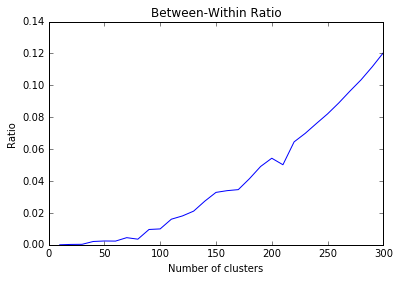

In [383]:
btwn_within_ratio = np.divide(between, within)
plt.plot([x for x in range(10, 310, 10)], btwn_within_ratio)
plt.title('Between-Within Ratio')
plt.xlabel('Number of clusters')
plt.ylabel('Ratio')
plt.show()

# RadLex Category Tracker

In [50]:
example = []
for terms in three_most_freq_terms:
    for term in terms:
        if term[0] == "":
            example.append("abscess")
        elif term[0] == "polyp":
            example.append("lateral")
        else:
            example.append(term[0])

# Remove all underline
example = [tm.replace("_", " ") for tm in example]

In [51]:
# Modify some terms in a list
flag = 0
for x, tt in enumerate(example):
    if flag == 0 and tt == "fossa":
        example[x] = "fourth ventricle"
        flag = 1
        print("CHANGE")
    elif flag == 1 and tt == "fossa":
        example[x] = "fourth ventricle"
        flag = 2
        print("CHANGE one more")

In [52]:
# Re-define variable
radlex_term_category_list = pd.read_csv("Radlex.csv")

In [53]:
term_category_dict = {}
clus_idx = 1
for x, term in enumerate(example):
    hier = ""
    terms = ""

    target = radlex_term_category_list[radlex_term_category_list["Name or Synonym"].values == term]
    hier += target["Name or Synonym"].values+" => "
    terms += target["Name or Synonym"].values+","
    # Loop through until it reaches to the root

    try:
        while target["Parent RID"].values[0] != "RID1":
            parent_rid = target["Parent RID"].values[0]
            target = radlex_term_category_list[radlex_term_category_list["RID"] == parent_rid]
#             print(target)
            hier += target["Name or Synonym"].values+" => "
            terms += target["Name or Synonym"].values+","

        terms_list = unlist(terms).strip().split(",")

        terms_list = terms_list[1:-1]

        if terms_list[-1] not in term_category_dict.keys():
            term_category_dict[terms_list[-1]] = {}
            for term in terms_list:
                if term not in term_category_dict[terms_list[-1]].keys():
                    term_category_dict[terms_list[-1]][term] = 1
                else:
                    term_category_dict[terms_list[-1]][term] += 1
        else:
            for term in terms_list:
                if term not in term_category_dict[terms_list[-1]].keys():
                    term_category_dict[terms_list[-1]][term] = 1
                else:
                    term_category_dict[terms_list[-1]][term] += 1

        if x % 8 == 0:
            print("============CLUSTER "+str(clus_idx)+"==============")
            print("===============")
            clus_idx += 1

        print(hier)
    except IndexError:
        continue

============CLUSTER 1==============
[ 'liver => lobular organ => parenchymatous organ => solid organ => organ => anatomical structure => material anatomical entity => anatomical entity => ']
[ 'bone marrow => zone of bone organ => organ zone => organ region => cardinal organ part => anatomical structure => material anatomical entity => anatomical entity => ']
[ 'neuroblastoma => neuroepitheliomatous neoplasm => neoplasm => proliferation => pathophysiologic finding => clinical finding => ']
['present => quantity descriptor => Radlex descriptor => ']
['treatment => procedure => ']
['midline => location descriptor => Radlex descriptor => ']
============CLUSTER 2==============
['osteomyelitis => infection => infectious or inflammatory disease => pathophysiologic finding => clinical finding => ']
['infection => infectious or inflammatory disease => pathophysiologic finding => clinical finding => ']
['acute => temporal descriptor => Radlex descriptor => ']
['adjacent => location descriptor =

In [57]:
# Find Clusteroids
# Iterate through all clusters

clusteroids_list = []
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,61):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in dis_tf.columns]
    term_lists = [dis_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia' or term == 'bones':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 
    #print the 3 most freq terms in DDX category
#     print(str(c))

    clean_count_asdict = count_asdict
    print(str(c)+"!++++++++++++++++++++++++++++")
    print(count_asdict)
    print("++++++++++++++++++++++++++")
    three_most_freq_terms.append(count_asdict[:8])
    
#     del wc, count_asdict, term_lists # For memory efficiency

# pd.DataFrame(dict(count_asdict[:5]).keys()).to_csv("tmft.csv")

1!++++++++++++++++++++++++++++
[('liver', 65), ('bone_marrow', 48), ('may_be', 48), ('neuroblastoma', 47), ('present', 43), ('treatment', 38), ('midline', 37), ('therapy', 36), ('chemotherapy', 31), ('invasion', 29), ('adrenal_gland', 24), ('origin', 24), ('solid', 23), ('rhabdomyosarcoma', 23), ('residual', 23), ('regional', 22), ('diagnosis', 21), ('sonography', 20), ('neoplasm', 20), ('kidney', 19), ('tumor', 19), ('abdomen', 18), ('malignant', 18), ('lower', 18), ('organ', 17), ('after', 16), ('extracranial', 16), ('lesion', 16), ('pelvis', 16), ('microscopic', 15), ('tissue', 15), ('lymph_node', 15), ('obstructed', 14), ('limited', 14), ('nerve', 14), ('lungs', 14), ('surgery', 14), ('vaginal', 12), ('complete', 10), ('contralateral', 10), ('incomplete', 10), ('unilateral', 10), ('location', 9), ('biopsy', 9), ('metastasis', 9), ('skeleton', 9), ('soft_tissue', 9), ('brain', 9), ('extension', 8), ('leukemia', 8), ('cortex', 7), ('hemorrhage', 7), ('mediastinum', 7), ('retroperiton